In [1]:
import pandas as pd

import numpy as np

import matplotlib
matplotlib.use('Qt5Agg')  # Cambia el backend a Qt5Agg para mostrar ventanas gráficas
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from pymoo.core.problem import ElementwiseProblem

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

from matplotlib import style

#Para que el primer punto sea el inicial
from pymoo.core.repair import Repair 

#Diferentes funciones de la biblioteca para optimizar (pymoo)
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.mutation.bitflip import BitflipMutation

import logging

In [2]:
from lxml import etree

# Ruta a tu archivo XML y DTD
xml_file = '/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/flight_plan_pruebaQT_2.xml'
dtd_file = '/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/flight_plan.dtd'

# Cargar el DTD
with open(dtd_file, 'r') as dtd_f:
    dtd = etree.DTD(dtd_f)

# Cargar el archivo XML
with open(xml_file, 'r') as xml_f:
    xml_content = xml_f.read()

# Validar el XML contra el DTD
try:
    xml_doc = etree.fromstring(xml_content)
    if dtd.validate(xml_doc):
        print("El archivo XML es válido.")
    else:
        print("El archivo XML no es válido.")
        print("Errores:")
        for error in dtd.error_log:
            print(f"Línea {error.line}: {error.message}")
except etree.XMLSyntaxError as e:
    print("Error de sintaxis XML:")
    print(e)


El archivo XML es válido.


In [21]:
#En primer lugar cargamos todos los archivos necesarios. Estos son los siguientes:
#1- Datos.txt -> Nos dice si queremos mapa o no, número de segmentos y número de puntos de control
#3- flight_plan -> Nos da todos los datos de lo que se desea en la ruta (Puntos de paso, regiones...)

#Leemos los archivos sacados del boton de planificación
Estrategia = pd.read_csv('/home/dacya-iagesbloom/Desktop/PprzGCS/datos.txt', delimiter=':', header = None) #Datos.txt

#Carga de archivo XML
import xml.etree.ElementTree as ET
from xml.dom import minidom

tree = ET.parse('/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/flight_plan_pruebaQT_2.xml')
root = tree.getroot()

# Encontrar todos los waypoints
way_points = root.find('waypoints')
waypoint_list = []
unchanged_points = []
home = []
#RECORDATORIO CHECKPOINT: EL CÓDIGO ESTABA HECHO PARA DECLARAR LAS VARIABLES CON X,Y NO CON LON LAT. EL PROBLEMA VIENE DE QUE CON
#EL FLIGHT_PLAN HECHO POR MI EL SIMULADOR NO SIGUE BIEN LA RUTA. POR TANTO, ESTOY PROBANDO CON UNO QUE (A VECES) SÍ QUE HACE BIEN 
#LA RUTA. PERO HAY QUE O PASAR LON Y LAT A X E Y O QUE SEA CAPAZ DE LEER LON, LAT

# Almacenar los waypoints existentes en una lista
for waypoint in way_points.findall('waypoint'):
    name = waypoint.get('name')
    #print(name)
    if name.startswith('BZ'):
        #lat = float(waypoint.get('lat'))
        #lon = float(waypoint.get('lon'))
        x = float(waypoint.get('x'))
        y = float(waypoint.get('y'))
        #print(waypoint.get('lon'))
        #print(lon)
        #print(type(lat))
        waypoint_list.append((name, x, y))
        #waypoint_list.append((name, lat, lon))
        #print("Punto", x, y)
    else:
        x = float(waypoint.get('x'))
        y = float(waypoint.get('y'))
        unchanged_points.append((name, x, y))
        #waypoint_list.append((name, lon, lat))
    if name == "HOME":
        home.append((name, x, y))
        waypoint_list.append((name, x, y))
        #print(unchanged_points)
#print("Unchanged:", unchanged_points)

sectors = {}
sectors_names = []
for sector in root.find('sectors'):
    sector_name = sector.attrib['name'] 
    sectors_names.append(sector_name)
    corners = []
    for corner in sector.findall('corner'):
        corner_name = corner.attrib['name']
        #print("Corner name: ", corner_name)
        
        # Comprobar si corner_name está en unchanged_points
        for name, x, y in unchanged_points:
            if corner_name == name:
                #print("Point: ", (x, y))
                corners.append((x, y))
                break  # Salir del bucle una vez que se encuentra el punto

    sectors[sector_name] = corners

print("Sectors: ", sectors)


#Limpiamos way_points
way_points.clear()

#Convertimos tanto la lista de waypoints como unchanged en una lista y las unimos
waypoints = np.array([[nombre, lat, lon] for nombre, lat, lon in waypoint_list])
unchangedpoints = np.array([[nombre, x, y] for nombre, x, y in unchanged_points])
sectors_points=[]
for sector_name, coords in sectors.items():
    for coord in coords:
        sectors_points.append((sector_name, coord[0], coord[1]))
sectors_array = np.array(sectors_points, dtype=object)
#sectors = np.array([[nombre, x, y] for nombre, x, y in sectors])
points = np.concatenate((waypoints, unchangedpoints), axis=0)

print("Sectors_array: ", sectors_array)

Sectors:  {'Net': [(-8.9, 18.5), (-8.8, 12.0), (-14.3, 11.7), (-14.7, 17.8)], 'Region1': [(-13.5, 32.2), (-4.4, 32.5), (-4.3, 27.8), (-13.2, 26.9)]}
Sectors_array:  [['Net' -8.9 18.5]
 ['Net' -8.8 12.0]
 ['Net' -14.3 11.7]
 ['Net' -14.7 17.8]
 ['Region1' -13.5 32.2]
 ['Region1' -4.4 32.5]
 ['Region1' -4.3 27.8]
 ['Region1' -13.2 26.9]]


In [22]:
#Ahora hay que calcular el centroide de cada sector y añadirlo a las paradas

def calcular_centroide(puntos):
    n = len(puntos)  # Número de vértices
    C_x = sum(x for x, y in puntos) / n  # Promedio de las coordenadas x
    C_y = sum(y for x, y in puntos) / n  # Promedio de las coordenadas y
    return C_x, C_y  # Devuelve el centroide como una tupla

#Definimos una matriz unicamente con las coordenadas de cada parada:
paradas = np.array(waypoints[:,-2:])
print("Paradas:\n", paradas)
#Definimos parámetros del barco
velocidad_media = 40

centroides = []

for i in range(len(sectors_names)):
    C_x, C_y = calcular_centroide(sectors[sectors_names[i]])
    print("Puntos del centroide:\n", sectors[sectors_names[i]])
    C_i = [C_x, C_y]
    centroides.append(C_i)
centroides = np.array(centroides)
print("Centroides:\n", centroides)
paradas=np.vstack((paradas, centroides))
print("Paradas actualizadas:\n", paradas)

Paradas:
 [['0.0' '0.0']
 ['-18.4' '8.9']
 ['2.3' '36.0']
 ['-19.8' '22.2']
 ['-20.8' '35.0']
 ['-11.8' '22.3']]
Puntos del centroide:
 [(-8.9, 18.5), (-8.8, 12.0), (-14.3, 11.7), (-14.7, 17.8)]
Puntos del centroide:
 [(-13.5, 32.2), (-4.4, 32.5), (-4.3, 27.8), (-13.2, 26.9)]
Centroides:
 [[-11.675  15.   ]
 [ -8.85   29.85 ]]
Paradas actualizadas:
 [['0.0' '0.0']
 ['-18.4' '8.9']
 ['2.3' '36.0']
 ['-19.8' '22.2']
 ['-20.8' '35.0']
 ['-11.8' '22.3']
 ['-11.675' '15.0']
 ['-8.85' '29.85']]


In [23]:
class StartFromZeroRepair(Repair):

    def _do(self, problem, X, **kwargs):
        I = np.where(X == 0)[1]

        for k in range(len(X)):
            i = I[k]
            X[k] = np.concatenate([X[k, i:], X[k, :i]])

        return X

In [24]:
import matplotlib
matplotlib.use('Qt5Agg')  # Cambia el backend a TkAgg para mostrar ventanas gráficas
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

from pymoo.core.problem import ElementwiseProblem


class RUTA (ElementwiseProblem):

    def __init__(self, **kwargs):

        n_stops, _ = stops.shape #Aquí coge las filas (Por tanto el número de paradas)
        #n_stops=n_stops-1
        self.stops = stops
        self.D = cdist(stops, stops)

        super(RUTA, self).__init__(
            n_var=n_stops,
            n_obj=2,
            n_constr=2,
            xl=0,
            xu=len(stops),
            vtype=int,
            **kwargs
        )

    def _evaluate(self, x, out, *args, **kwargs):
        distancia=self.get_route_length(x)
        tiempo=self.get_route_length(x)/velocidad_media
        out['F'] = [distancia, tiempo]

        #Voy a poner aquí las restricciones
        #Restricciones
        
        Max_dist=self.get_route_length(x)-250
        
        Max_tiempo=self.get_route_length(x)/velocidad_media-250

        x_ord=np.sort(x)
        penalty_paradas=0
        for i in range(len(x_ord)-1):
            if x_ord[i] == x_ord[i+1]:
                penalty_paradas=10000
                
        out["G"]=[Max_dist, Max_tiempo + penalty_paradas]
        
    def get_route_length(self, x):
        n_stops = len(x)
        dist = 0
        for k in range(n_stops - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]
        return dist


def visualize_3(problem, x, n, sectors, fig=None, ax=None, show=True, label=True):
 with plt.style.context('ggplot'):
        x=x[0]
        if fig is None or ax is None:
            fig, ax = plt.subplots()

        # plot cities using scatter plot
        ax.scatter(problem.stops[:, 0], problem.stops[:, 1], s=150)
        if label:
            # annotate cities
            for i, c in enumerate(problem.stops):
                ax.annotate(str(i), xy=c, fontsize=10, ha="center", va="center", color="white")

        # plot the line on the path
        for i in range(len(x)-1):
            current = x[i]
            next_ = x[(i + 1)]
            ax.plot(problem.stops[[current, next_], 0], problem.stops[[current, next_], 1], 'r--')

        # Ploteamos los sectores
        for sector_name, points in sectors.items():
            sector_points = np.array(points)
            ax.fill(sector_points[:, 0], sector_points[:, 1], alpha=0.2, label=f'Sector {sector_name}')
         
        fig.suptitle(f"Route length: {problem.get_route_length(x)}km \nRoute time: {problem.get_route_length(x)*60/velocidad_media}min")

        if show:
            fig.show()

            X, F = res.opt.get("X", "F")
    
        from pymoo.visualization.scatter import Scatter
        
        plot = Scatter()
        plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
        plot.add(res.F, facecolor="none", edgecolor="red")
        %matplotlib inline
        plot.show()


In [25]:

def closest_point_and_reorder(home, points):

    # Convertir las coordenadas de los puntos a un numpy array y trabajar solo con las coordenadas (últimas 2 columnas)
    coords = np.array(points[:, -2:], dtype=float)
    
    # Convertir el punto fijo a un array numpy
    home = np.array(home, dtype=float)
    
    # Calcular las distancias euclidianas entre el punto fijo y cada punto de 'coords'
    distances = np.linalg.norm(coords - home, axis=1)
    
    # Encontrar el índice del punto con la menor distancia
    closest_index = np.argmin(distances)
    
    # Reordenar los puntos colocando el más cercano en la primera posición
    reordered_points = np.vstack([points[closest_index], np.delete(points, closest_index, axis=0)])
    
    return reordered_points, closest_index
        
home_coord = home[0][1:]
waypoint_list = [(x, y) for (_, x, y) in waypoint_list]
waypoint_list, closest_index = closest_point_and_reorder(home_coord, paradas)
paradas = waypoint_list
print(waypoint_list)

[['0.0' '0.0']
 ['-18.4' '8.9']
 ['2.3' '36.0']
 ['-19.8' '22.2']
 ['-20.8' '35.0']
 ['-11.8' '22.3']
 ['-11.675' '15.0']
 ['-8.85' '29.85']]


In [26]:
#Para en caso en el que tengamos más de un barco hará un clustering con kmeans para clasificar las diferentes paradas

n_barcos = 1

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

x_k, y=paradas[0], paradas[1]
X_scaled = scale(paradas)
modelo_kmeans = KMeans(n_clusters=n_barcos, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)

# Clasificación con el modelo kmeans

y_predict = modelo_kmeans.predict(X=X_scaled)

#Representación
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i in np.unique(y_predict):
    ax.scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1], 
    c = 'black',
    s = 40,
    marker = 'o',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

0
Maximum Span: [83.406  2.085]
Function Evaluations: 2000
[[0 1 6 5 3 4 7 2]]


/tmp/ipykernel_12015/2384214916.py:85: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


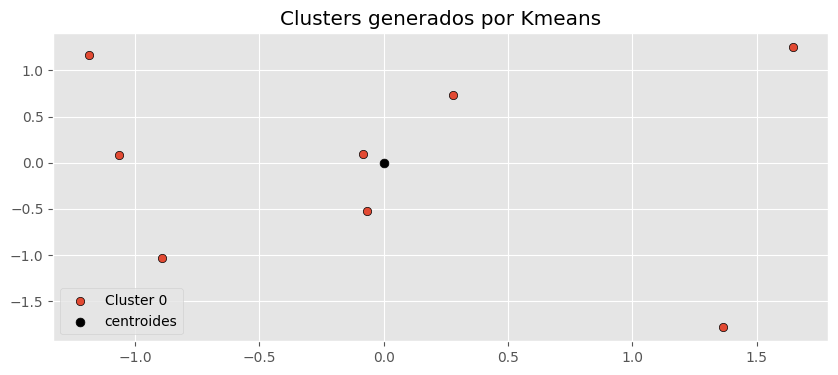

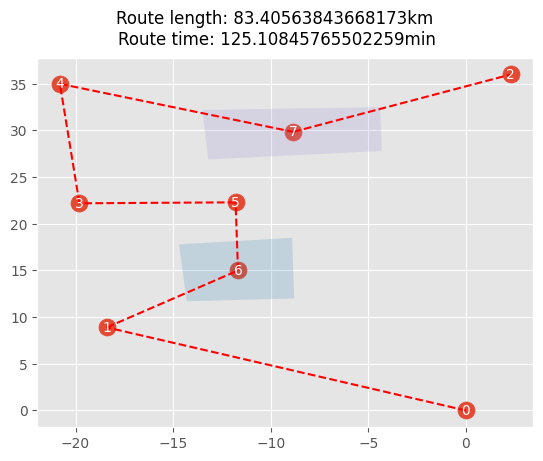

In [27]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.mutation.bitflip import BitflipMutation

#Creamos un diccionario para almacenar cada ruta
rutas={}
waypoint_list = np.array(waypoint_list, dtype=object)
stops = waypoint_list.astype(float)
#print(stops)
fitness=[]

for i in range(n_barcos):
    print(i)
    grupos_finales=np.array([stops[:, 0], stops[:, 1], y_predict])
    grupos_finales=grupos_finales.T
    rutas[f"ruta_{i}"]=grupos_finales[grupos_finales[:,2]==i][:,:2]
from pymoo.core.sampling import Sampling
for i in range(n_barcos):
    n_stops=len(stops)
    problem = RUTA()

        
    class CustomSampling(Sampling):
        def _do(self, problem, n_samples, **kwargs):
            # Generar n_samples rutas aleatorias
            samples = []
            for _ in range(n_samples):
                # Crear una ruta aleatoria (permutación de las paradas)
                route = np.random.permutation(n_stops)
                #print(f"n_paradas {n_stops}")
                samples.append(route)
                #print(f"samples {samples}")
            return np.array(samples)

    sampling=CustomSampling()  
    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling,
        mutation=InversionMutation(),
        #mutation=BitflipMutation(),
        crossover=OrderCrossover(),
        repair=StartFromZeroRepair(),
        eliminate_duplicates=True,
        save_history=True,
        #verbose=True
    )
    
    # if the algorithm did not improve the last 200 generations then it will terminate (and disable the max generations)
    #termination = DefaultSingleObjectiveTermination(period=200, n_max_gen=np.inf)
    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen',100),
        seed=1,
        verbose=False,
    )
    print("Maximum Span:", np.round(res.F[0], 3))
    print("Function Evaluations:", res.algorithm.evaluator.n_eval)
    
    print(res.X)
    %matplotlib inline
    visualize_3(problem, res.X, n_barcos, sectors)
    


In [28]:
res.X[0][0] = closest_index
print(res.X)
mascara = (res.X <= closest_index)
mascara[0] = False
res.X[mascara]-=1
print(res.X)

[[0 1 6 5 3 4 7 2]]
[[0 1 6 5 3 4 7 2]]


In [29]:
paradas[1]

array(['-18.4', '8.9'], dtype='<U32')

In [30]:
res.X[0][1]

1

In [31]:
#En este vector vamos a tener el orden del TSP pero con las coordenadas
resultado = []

for i in range(len(res.X[0])):

    idx = res.X[0][i]
    resultado.append(paradas[idx])

resultado = np.vstack(resultado)

In [32]:
resultado

array([['0.0', '0.0'],
       ['-18.4', '8.9'],
       ['-11.675', '15.0'],
       ['-11.8', '22.3'],
       ['-19.8', '22.2'],
       ['-20.8', '35.0'],
       ['-8.85', '29.85'],
       ['2.3', '36.0']], dtype='<U32')

2
Indice =  6
Sector indice =  2
punto_inicial 1
punto_final 5


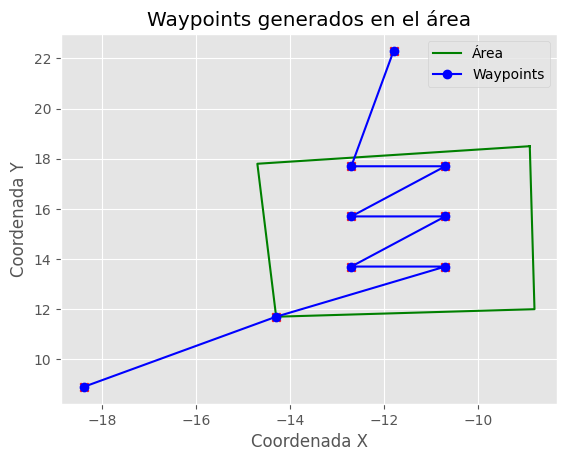

2
Indice =  7
Sector indice =  6
punto_inicial 4
punto_final 2


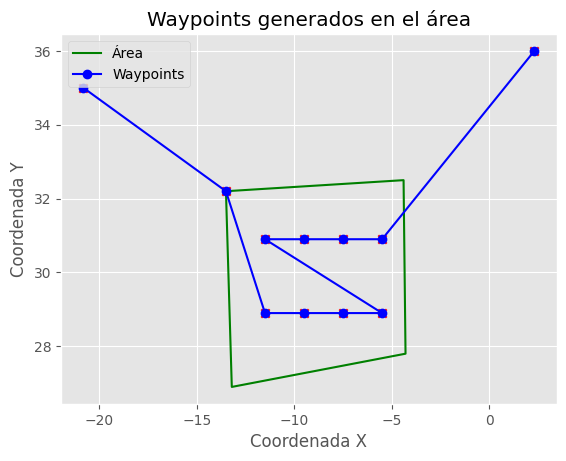

In [33]:
# Importar bibliotecas necesarias
from shapely.geometry import Polygon, Point
import numpy as np
import matplotlib.pyplot as plt
import math

# Función para generar waypoints en un área determinada
def generar_waypoints_area(polygon, vertices, paso, x_inicio, y_inicio, x_fin, y_fin):
    waypoints = []
    min_x, min_y, max_x, max_y = polygon.bounds
    y_vals = np.arange(min_y, max_y, paso)
    x_vals = np.arange(min_x, max_x, paso)
    
    # Asegurarse de que los puntos de inicio son flotantes
    waypoints.append((float(x_inicio), float(y_inicio)))

    # Calcular las distancias a los vértices
    dists = []
    for i in range(len(vertices)):
        vertice = np.array(vertices[i], dtype=float)
        dist = np.linalg.norm(vertice - np.array((float(x_inicio), float(y_inicio))))
        dists.append(dist)
    
    # Obtener el punto más cercano
    min_index = np.argmin(dists)
    closest_point = tuple(map(float, vertices[min_index]))  # Asegúrate de que es una tupla de flotantes
    waypoints.append(closest_point)  # Agregar el punto más cercano

    punto_final = (float(x_fin), float(y_fin))

    # Controlar el orden de los puntos
    if punto_final[1] < (max_y / 2):
        y_vals = np.flip(y_vals)
    if punto_final[0] < (max_x / 2):
        x_vals = np.flip(x_vals)

    # Generar waypoints dentro del polígono
    for y in y_vals:
        for x in x_vals:
            point = Point(x, y)
            if polygon.contains(point):
                waypoints.append((float(x), float(y)))  # Asegurarte de que son flotantes

    # Añadir el punto final
    waypoints.append(punto_final)

    return waypoints

long_añadidos = 0
resultados_sectores = [list(map(float, punto)) for punto in resultado]
# Suponiendo que tienes un bucle que llama a esta función con los parámetros adecuados
for i in range(len(sectors_names)):
    
    poligono = Polygon(sectors[sectors_names[i]])
    vertices = sectors[sectors_names[i]]
    orden = 2
    print(orden)
    
    # Obtener coordenadas iniciales y finales
    print("Indice = ", len(paradas) - len(sectors) + i)
    sector_indice = int(np.where(res.X == len(paradas) - len(sectors) + i)[1])
    print("Sector indice = ",sector_indice)
    punto_inicial = res.X[0][sector_indice - 1]
    print("punto_inicial", punto_inicial)
    punto_final = res.X[0][sector_indice + 1]
    print("punto_final", punto_final)
    x_ini = paradas[punto_inicial, 0]
    y_ini = paradas[punto_inicial, 1]
    x_fin = paradas[punto_final, 0]
    y_fin = paradas[punto_final, 1]

    waypoints = generar_waypoints_area(poligono, vertices, orden, x_ini, y_ini, x_fin, y_fin)
    #print("Long wp", len(waypoints))
    #print("Long res ini", len(resultados_sectores
    resultados_sectores = np.delete(resultados_sectores, sector_indice + long_añadidos, axis = 0)
    resultados_sectores = np.insert(resultados_sectores, sector_indice + long_añadidos, waypoints, axis = 0)
    #print("Long res final",len(resultados_sectores))
    long_añadidos+=len(waypoints)-1
    # Verifica el contenido antes de graficar
    #print("Waypoints:", waypoints)

    #print("Resultado sectores: ", resultados_sectores)
    # Dibujar el área y los waypoints
    x_coords, y_coords = zip(*waypoints)

    # Dibujar el área (polígono)
    x_poly, y_poly = poligono.exterior.xy
    plt.plot(x_poly, y_poly, color='green', label='Área')
    
    # Dibujar el recorrido (waypoints)
    plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Waypoints')
    plt.scatter(x_coords, y_coords, marker='x', color='red')  # Marcar los puntos
    plt.title('Waypoints generados en el área')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid(True)
    plt.legend()
    plt.show()

In [34]:
vertices[0][1]

32.2

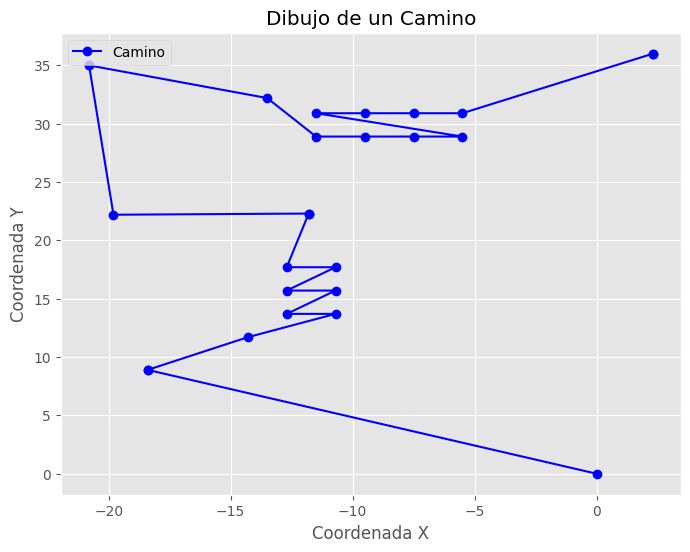

In [35]:
# Crear el gráfico
plt.figure(figsize=(8, 6))

# Dibujar el camino
plt.plot(resultados_sectores[:,0], resultados_sectores[:,1], marker='o', linestyle='-', color='b', label='Camino')

# Agregar etiquetas y título
plt.title('Dibujo de un Camino')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.legend()

# Mostrar el gráfico
plt.show()
